In [ ]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount("Mydrive", force_remount=True)

Mounted at Mydrive


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import average_precision_score

In [ ]:
# constant

MOBILENET_MODEL_DIR = '/content/Mydrive/MyDrive/Colab Notebooks/CUB200/models/best_mobilenet.h5'
TEST_DATADIR = '/content/Mydrive/MyDrive/Colab Notebooks/CUB200/test'
IMG_SIZE = (160, 160)
BATCH_SIZE = 64
NUM_CLASSES = 200
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
def create_test_dataset(img_size):
    test_dataset = tf.keras.utils.image_dataset_from_directory(
        TEST_DATADIR,
        shuffle=False,
        batch_size=BATCH_SIZE,
        image_size=img_size,
    )
    # class_names = test_dataset.class_names
    test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)
    return test_dataset

In [ ]:
test_dataset = create_test_dataset(IMG_SIZE)

Found 1204 files belonging to 200 classes.


In [ ]:
def evaluate_model(directory, test_dataset):
    model = load_model(directory)

    # Extract true labels from test_dataset for later use
    y_true = []
    for _, labels in test_dataset:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)

    # top-1 accuracy: evaluate overall classfication performance
    loss, top_1_accuracy = model.evaluate(test_dataset)
    # print(f"Top-1 Accuracy: {top_1_accuracy * 100:.2f}%")

    # top-5 accuracy: any of your model 5 highest probability answers must match the expected answer.
    # Get predicted probabilities from the model
    y_pred_probs = model.predict(test_dataset)

    # Get top 5 predicted class indices for each prediction
    top_5_preds = np.argsort(y_pred_probs, axis=-1)[:, -5:]

    # Check if true label is among top 5 predictions for each sample
    correct_top_5 = [true in top_5 for true, top_5 in zip(y_true, top_5_preds)]

    # Compute Top-5 Accuracy
    top_5_accuracy = np.mean(correct_top_5)

    # print(f"Top-5 Accuracy: {top_5_accuracy * 100:.2f}%")


    # Average accuracy per class: assess the performance of an individual class

    # Predict on the test dataset
    y_pred = model.predict(test_dataset)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Extract true labels from test_dataset
    y_true = []
    for _, labels in test_dataset:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)

    # Calculate per-class accuracy
    correct_counts = [0] * NUM_CLASSES
    total_counts = [0] * NUM_CLASSES

    for true, pred in zip(y_true, y_pred_classes):
        total_counts[true] += 1
        if true == pred:
            correct_counts[true] += 1

    # Calculate accuracy per class
    T = [correct / total for correct, total in zip(correct_counts, total_counts)]

    # Average accuracy across all classes
    Ave = sum(T) / NUM_CLASSES

    # print(f"Average accuracy per class: {Ave * 100:.2f}%")

    # Mean average precision (mAP):
    # calculate the average precision (AP) for each
    # class and then average among all classes

    # Here's a step-by-step guide to calculate the mAP for your model:

    # 1. For each class:
    # 1.1. Rank the predictions by their predicted probability for that class.
    # 1.2. Calculate the precision and recall at each prediction threshold.
    # 1.3. Compute the AP for the class, which is the areaunder the precision-recall curve.

    # 2. Compute the mAP, which is the mean of the APs for all classes.



    # Assuming y_true is your list of true labels, with one label per sample
    y_true_onehot = tf.keras.utils.to_categorical(y_true, NUM_CLASSES)

    # Calculate AP for each class
    APs = [average_precision_score(y_true_onehot[:, i], y_pred_probs[:, i]) for i in range(NUM_CLASSES)]

    # Compute the mAP as the mean of the APs for all classes
    mAP = np.mean(APs)

    # print(f"Mean Average Precision (mAP): {mAP * 100:.2f}%")
    return top_1_accuracy, top_5_accuracy, Ave, mAP

In [ ]:
top_1_accuracy, top_5_accuracy, Ave, mAP = evaluate_model(MOBILENET_MODEL_DIR, test_dataset)

print(f"Top-1 Accuracy: {top_1_accuracy * 100:.2f}%")
print(f"Top-5 Accuracy: {top_5_accuracy * 100:.2f}%")
print(f"Average accuracy per class: {Ave * 100:.2f}%")
print(f"Mean Average Precision (mAP): {mAP * 100:.2f}%")

19/19 [==============================] - 36s 2s/step
Top-1 Accuracy: 56.98%
Top-5 Accuracy: 80.48%
Average accuracy per class: 56.26%
Mean Average Precision (mAP): 64.78%


Found 1204 files belonging to 200 classes.
2/2 [==============================] - 2s 603ms/step


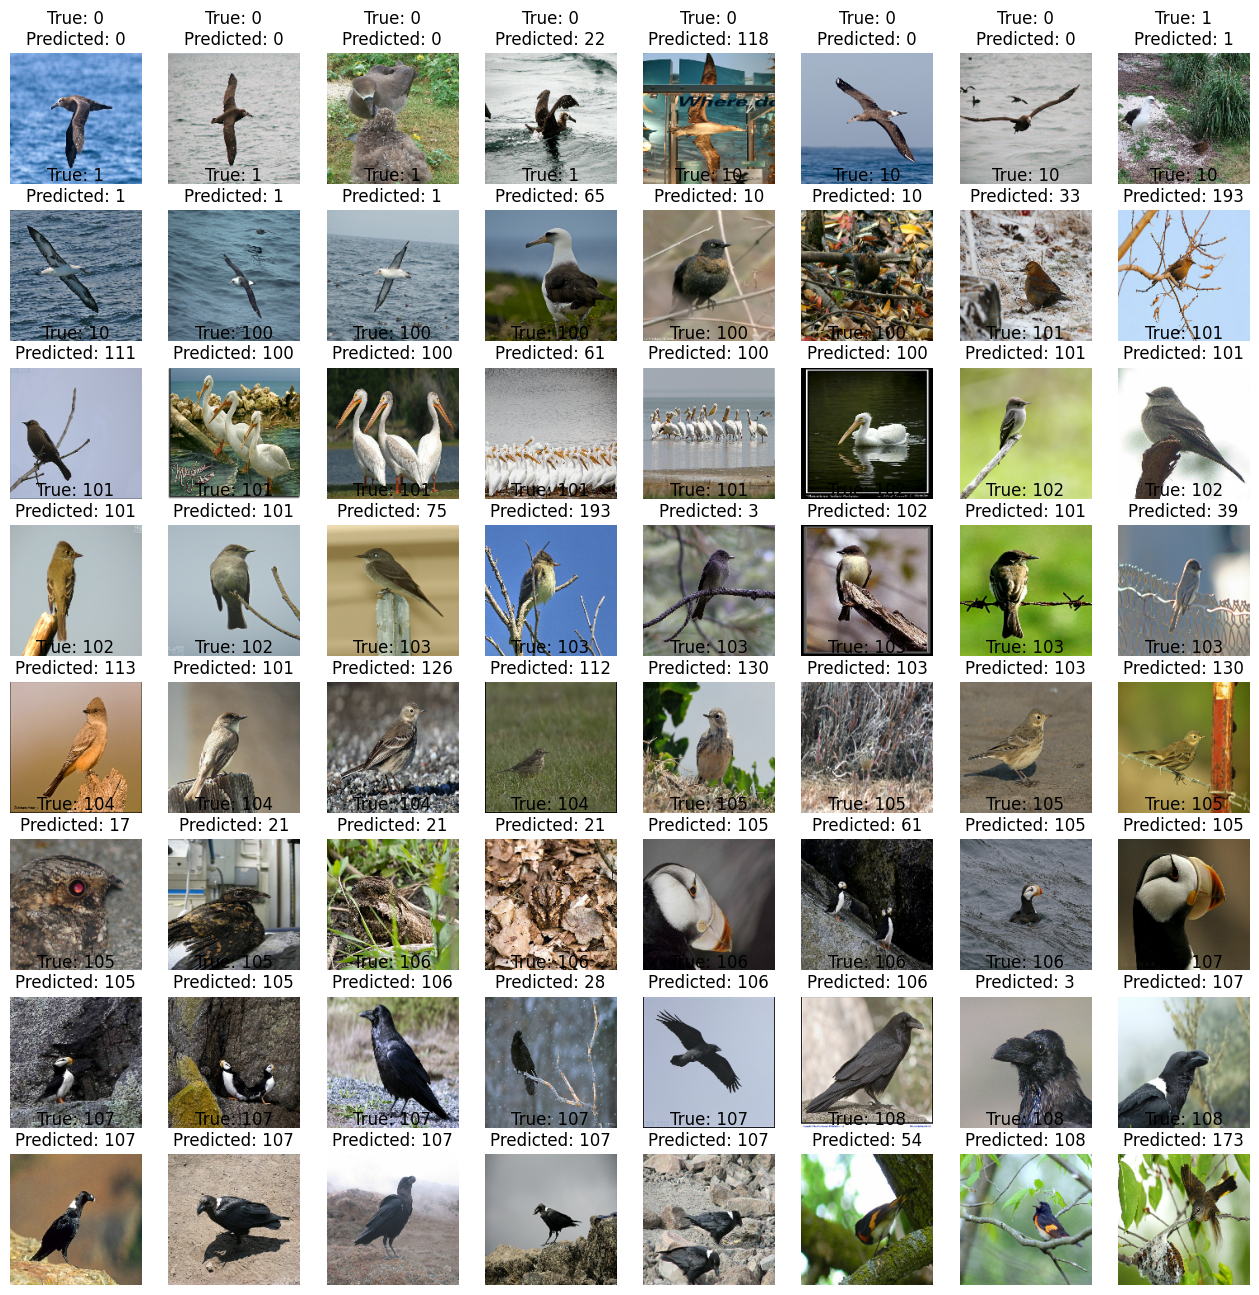

In [ ]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
        TEST_DATADIR,
        shuffle=False,
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
    )
class_names = test_dataset.class_names
test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

model = load_model(MOBILENET_MODEL_DIR)
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Assuming you've already defined constants and loaded the test_dataset and model

def plot_images(images, labels, predictions=None):
    """Display a list of images with their corresponding labels and (optional) predictions"""
    n = len(images)
    rows = int(n**0.5)
    cols = (n // rows) + int(n%rows != 0)

    fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))
    if predictions is None:
        predictions = [None] * len(labels)

    for img, label, prediction, ax in zip(images, labels, predictions, axes.ravel()):
        ax.imshow(img.numpy().astype("uint8"))
        ax.set_title(f"True: {label}\nPredicted: {prediction}")
        ax.axis("off")

# Extract a batch of images and labels from the test dataset
for test_images, test_labels in test_dataset.take(1):
    # Use the model to predict the class for each image
    predictions = model.predict(test_images)
    predicted_labels = [class_names[np.argmax(pred)] for pred in predictions]
    true_labels = [class_names[label] for label in test_labels.numpy()]

    plot_images(test_images, true_labels, predicted_labels)
    plt.show()
